# Evaluation exercises

Ensure that you document your code with brief explanations for each step. Use markdown cells for any comments or clarifications on your thought process and any observations made during the analysis.

## Exercise 1: Dimensionality Reduction and Clustering

Load the Iris dataset and perform the following steps:

1. Apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset into 2D. Make sure to project your data in 2D with the three types of flowers labeled (with colours,...). How much variation is explained by the two principal components?

<!-- Add an empty line here -->

2. Use k-means clustering on the PCA-transformed data and try to extract some clusters. How does the random_seed influence on the results?

<!-- Add an empty line here -->

3. Compute the Silhouette Score and Adjusted Rand Index (ARI) for the k-means clustering, considering the known labels of the three types of flowers in the Iris dataset.

# Answers To exercise 1

## Package and data import

Before we get started we need to load the required packages (package for both exercises 1,2 and 3 are listed below). Also we need to import the dataset and explore it a bit to get a feel for the type of data.

In [322]:
# ------- import required packages-------- #
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD



# --------DATA IMPORT--------- #
# import iris dataset
iris = datasets.load_iris()

# Create the Pandas df from the iris dataset
iris_df = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])

# Add  target variable (species)
iris_df['species'] = iris['target']

# Check for duplicate rows (all occurrences marked as True)
all_duplicates = iris_df[iris_df.duplicated(keep=False)]

# Display all rows that are considered duplicates
print("All Duplicate Rows:")
print(all_duplicates)

# Let's check null values
print(iris_df.isnull().sum()) # no null values

# Obtain some details about the dataset
display(iris_df.describe())



All Duplicate Rows:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
101                5.8               2.7                5.1               1.9   
142                5.8               2.7                5.1               1.9   

     species  
101        2  
142        2  
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


We have used pandas duplicate function to check for duplicates. There is one instance that comes up as a potential duplicate, however as our continuous data is not super refined (cm scale with 1 decimal) it may very well be possible that these are different entries with the same specfications. Therefore we do not remove these. Additionally we see that we have no null values. Using *iris_df.describe()* we obtain some descriptive information about the dataset. We can see that the species column is treated as continuous, this is something we should keep in mind for later analysis.

## Exercise 1.1: PCA analysis

Here we will perform dimensionality reduction using PCA. As this process involves scaling, it is important to exclude our categorical variable (species) from the analysis. As you will see n_components is set to 2 in this case, essentially bringing us 2 principle components. After experimenting a bit we found that the first component captures a large amoount of total variance (92%) and the 2nd (5%) already a lot less already. Therefor, in this case adding more PCs does not make sense and use of n_components is 2 is justified.

Explained Variance Ratios: [0.92461872 0.05306648]


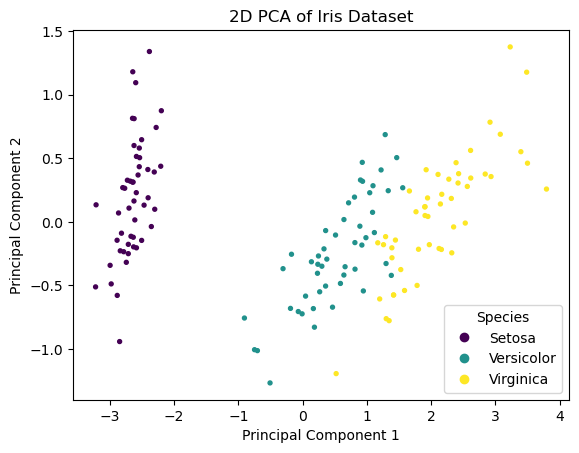

In [323]:
# --------Exercise 1.1:PCA Analysis--------- #
# Before we move to PCA we need to perform preprocessing to be able to scale only the continuous columns
X = iris_df.drop(['species'], axis=1)
Y = iris_df.species

# Now we perform scaling
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# set up number of components for PCA
n_components = 2

# Perform the PCA
pca2D = PCA(n_components=n_components)
proj_data = pca2D.fit_transform((X))

# Let's look at the variance explained by the 2 components.
print("Explained Variance Ratios:", pca2D.explained_variance_ratio_)  

# Set up the plot using viridis color map
scatter = plt.scatter(proj_data[:,0], proj_data[:,1], c=Y, cmap='viridis', s=8)

# set up the legend labels
legend_labels = ['Setosa', 'Versicolor', 'Virginica']
plt.legend(handles=scatter.legend_elements()[0], title="Species", labels=legend_labels)

# add additional details and plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Iris Dataset')
plt.show()


From our PCA plot we can see that our PCA provides a relatively clear separation of species. The three species are seperated along PC1 and variation within species is caught along PC2. We will now continue to perform k-means clustering on the results of this PCA analysis.

## Exercise 1.2: K-means clustering

Here we will perform K-means clustering on the PCA-transformed data. In this case, because we know the amount of unique species in the dataset is 3, we have set n_clusters = 3. The eventual centroids are overlaid on top of the PCA plot of the previous question.

c:\Users\tdormans\AppData\Local\miniconda3\envs\MScOmicsVic\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\tdormans\AppData\Local\miniconda3\envs\MScOmicsVic\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


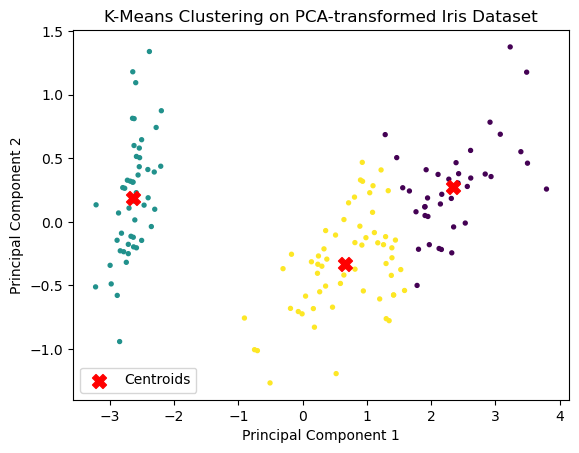

In [324]:

# --------Exercise 1.2:K-means clustering--------- #

# Number of clusters (for example here we choose three because we know there are 3 species in the set)
n_clusters = 3

# Perform k-means clustering on our PCA data
kmeans = KMeans(n_clusters=n_clusters, random_state=10)  # the random state value can change, we will discuss this in a bit
cluster_labels = kmeans.fit_predict(proj_data)

# Now we visualise our clusters
plt.scatter(proj_data[:, 0], proj_data[:, 1], c=cluster_labels, cmap='viridis', s=8)

# Add cluster centers to the plot
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=100, label='Centroids')

# Create a legend, axis labels, title and plot
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering on PCA-transformed Iris Dataset')
plt.show()



About random_state: Alterations in random_state can affect cluster formation. Different intitions can lead to different final cluster assignments. By changing the random_state, we can explore how sensitive K-means algorithm is to the initial conditions. If we try different random seeds, you might observe some variations in the resulting clusters.


## Exercise 1.3: Silhouette Score and Adjusted Rand Index (ARI)

In this step we utilize two metrics that provide reflection to the performance of our clustering: the silhouette score and the Adjusted Rand Index (ARI). The silhouette score provides insight in the intra-cluster compactness and the between clusters separation or the Ward's method. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The ARI is a measure of the similarity between two clusterings, adjusting for chance. The ARI considers all possible pairs of samples and then counts number of pairs that are assigned to the same or to different clusters in both the true labels and the predicted labels. It subsequently calculates a similarity index adjusted for chance, and ARD scores can range between -1 and 1 with a higher ARD indicating better agreement between  true and predicted labels.



In [325]:
# Silhouette Score
silhouette_avg = silhouette_score(proj_data, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(Y, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari}")


Silhouette Score: 0.597676421954799
Adjusted Rand Index (ARI): 0.7163421126838476


A silhouette score of ~0.6 indicates a relatively good but not perfect level of cluster separation. The ARD of ~0.7 suggests a relatively good match between predicted labels and true labels. 

# Questions Exercise 2: Regression and Classification

1. Implement a linear regression model to predict the sepal length (in cm) feature based on the other three features. Make sure to show the regression coeffcients obtained with the training dataset and the RMSE metric using a test dataset.

<!-- Add an empty line here -->

2. Create a logistic regression classifier to classify the three types of flowers in the Iris dataset based on the petal length and petal width. Make sure to evaluate the performance with the appropiate metrics and plot the decision boundaries.

<!-- Add an empty line here -->

3. Solve the same classification task problem but with a Support Vector Machine (SVM) classifier. Compare the performance with the logistic model you build.

# Answers Exercise 2

## Exercise 2.1: Linear Reqression

Here we will set up a linear regression model to predict sepal length based on the three other features. Therefore we need to exclude 'species' from this analysis and set sepal length as our target. We will obtain the regression coëfficients, intercept and the Root Mean Squared Error (RMSE). The RMSE is a measure of how well the model predictions align with the true values. RMSE represents the standard deviation of the residuals whereby lower RMSE values indicate better model performance.

In [326]:

# First we need to separate our target variable from the others and exclude species.
X = iris_df.drop(['sepal length (cm)', 'species'], axis=1)
Y = iris_df['sepal length (cm)']

# Next we split our data into training and testing sets. Here we select test size = 0.2. This means that 20% of total data will be used for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Set up and fit the linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, Y_train)


# Predict on the test set
Y_pred = linear_reg_model.predict(X_test)

# Extract the coefficients and the intercept
coefficients = linear_reg_model.coef_
intercept = linear_reg_model.intercept_

# Print Coefficients and intercepts by zipping their name and respective coefficient together
print("Regression Coefficients:")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef}")
print(f"Intercept: {intercept}")

# Print the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")





Regression Coefficients:
sepal width (cm): 0.6689970814690772
petal length (cm): 0.7237715717216028
petal width (cm): -0.5834113993550673
Intercept: 1.7949389290257258
Root Mean Squared Error (RMSE): 0.32914441422969726


Now we have obtained our regression coefficients and our RMSE. The coefficients represent the change in target variable for a 1 unit change in feature, given that the other features remain constant. For example we see that in our model a 1 cm increase in sepal width is associated with an increase in sepal length of ~0.67 cm. A 1 cm increase in petal width on the other hand is associated with an ~0.58 cm decrease in sepal length. The intercept represents the estimated value of the target variable when all the predictor variables are zero. However, in the case of the iris dataset this is not a meaningful value as it impossible to have sepal width, petal length, or petal width  equal to zero.
An RMSE of ~0.33 suggests that on average there is a difference of ~0.33 cm  between the predicted sepal length and the actual sepal length. As this still a relatively small number, our model is a relatively good predictor for sepal length.


## Exercise 2.2: Logistic Classifier
Here we create a logistic regression classifier model to classify  three types of flowers in the dataset based on  petal length and petal width. We will evaluate the performance of our regression model using numerous metrics that our set up in the defined *compute_evaluation_metrics()* function:

* Accuracy: Metric to gauges the model's overall correctness. Ratio of correctly predicted observations to the total number of observations.
* Precision: Also known as positive predictive value (PPV). A ratio of correctly predicted positive observations to the total of predicted positives
* Recall: Also known as sensitivity or True Positive Rate (TPR).  Used to measure the percentage of true positives amongst all positives
* F1 score: Harmonic mean of precision and recall.
Additionally we display a confusion matrix to get tabular insight into the predictive capabilities of our model.

We also set up the *plot_decision_boundary()* function to plot our decision boundaries. Decision boundaries are  dividing lines / surfaces that separate different classes in a classification problem. 

Let's first take a look at our plot:


C:\Users\tdormans\AppData\Local\Temp\ipykernel_9580\3301369959.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[Y == cl, 0], y=X[Y == cl, 1], alpha=1, c=cmap(idx), marker=markers[idx], label=cl)


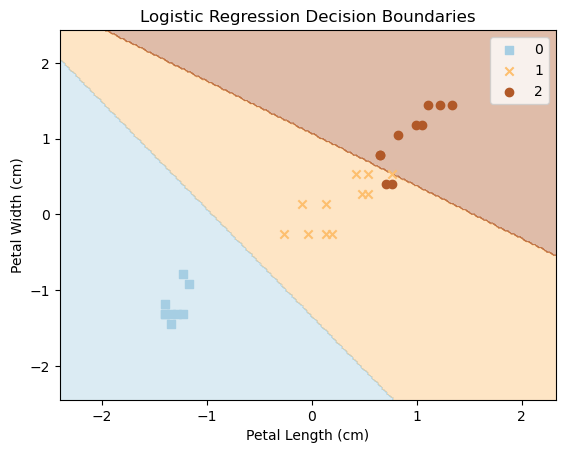

In [327]:
# Select the relevant columns
X = iris_df[['petal length (cm)', 'petal width (cm)']]
Y = iris_df['species']
scaler = StandardScaler()
X = scaler.fit_transform(X)
unique_labels = iris_df['species'].unique()


# Split dataset again
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

# Set up logistic regression
lr = LogisticRegression(random_state=41)
lr.fit(X_train, Y_train)

# Predict the species
Y_pred = lr.predict(X_test)


# Function to compute evaluation metrics
def compute_evaluation_metrics(model, X_test, Y_test, labels):
    Y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    #Precision, Recall and F1 Score
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    #Printing
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Confusion Matrix
    print('Confusion Matrix:')
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, display_labels=labels, xticks_rotation='vertical')
   

# Function to plot decision boundaries
def plot_decision_boundary(model, X, Y, resolution):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    cmap = plt.get_cmap('Paired', len(np.unique(Y)))

    # plot the decision surface setting up minimum and maximum values
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    # obtain model predictors by applying predicted to the flattened mesh grid
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)  # reshape to match the shape of mesh grid

    # create contour plot of decision surfaces
    plt.contourf(xx1, xx2, Z, cmap=cmap, alpha=0.4)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(Y)):
        plt.scatter(x=X[Y == cl, 0], y=X[Y == cl, 1], alpha=1, c=cmap(idx), marker=markers[idx], label=cl)
    
    # plot information/legend
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title('Logistic Regression Decision Boundaries')
    plt.legend()
    plt.show()

# Execute boundary plot with the corrected function
plot_decision_boundary(lr, X_test, Y_test, resolution=0.02)




We can see that our three different species are separated relatively well. The decision boundaries are linear, indicating good separation. Species '0' (Setosa), is clearly separated from the other two species. Species 1 (Versicolour) shows correct calling. For species 2 (Virginica) we see some false calling where its predictive label is Versicolour but in reality they are Virginica. Nonetheless, we have overall good separation. In other to get a more quantative insight into our model's predictive capabilities we can take a look at the aforementioned metrics and confusion matrix:

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Confusion Matrix:


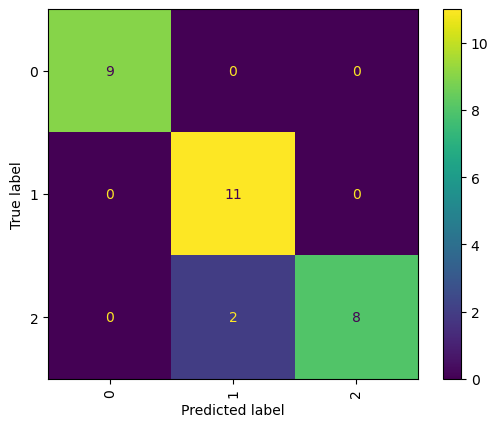

In [328]:
# Display the relevant metrics
compute_evaluation_metrics(lr, X_test, Y_test, unique_labels)

The model achieves a high overall accuracy of 93%, demonstrating its ability to make correct predictions. Additionally, with a precision of 94% and recall of 93%, it shows effective positive class identification while minimizing false positives. In the confusion matrix we see the 2 falsely called points in the graph (predicted label 1, true label 2)

## Exercise 2.3: Support Vector Machine classifier

Here we will employ a Support Vector Machine (SVM) classifier instead of a logistic regression classifier and see how their performances compare. SVM is a powerful machine learning algorithm which can be used for classification , aiming to find a hyperplane that will maximally separates the different classes in the feature space. SVM achieves this by identifying support vectors, which are crucial instances that can influence the placement of the decision boundary. It is important to note that SVM is capable of both linear and non-linear separation whereas logistic regression is only capable of linear separation.

In other to analyze the performance of the model we use the same functions as before (*plot_decision_boundary()*, *compute_evaluation_metrics()*) Let's take a look at the plot first:


C:\Users\tdormans\AppData\Local\Temp\ipykernel_9580\3301369959.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[Y == cl, 0], y=X[Y == cl, 1], alpha=1, c=cmap(idx), marker=markers[idx], label=cl)


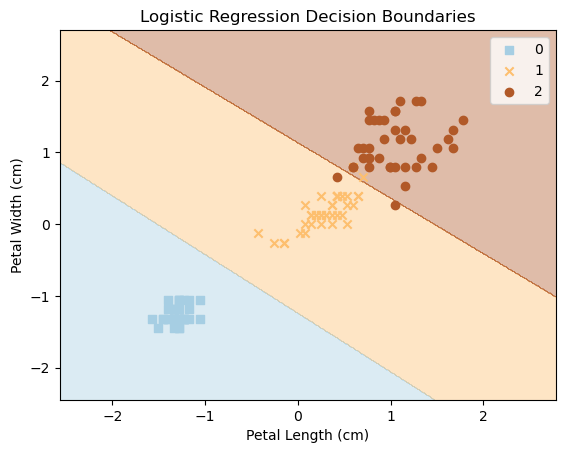

In [329]:
#set-up of dataset
X = iris_df[['petal length (cm)', 'petal width (cm)']]
Y = iris_df['species']
scaler = StandardScaler()
X = scaler.fit_transform(X)
unique_labels = iris_df['species'].unique()


# Split dataset again
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

svm = SVC(kernel = 'linear', C=1.0, random_state=42)
svm.fit(X_train, Y_train)

# Perform the plot
plot_decision_boundary(svm, X_train, Y_train, resolution=0.01)


We observe a very similar image to our logisitic regression plot. This indicates that the dataset is effectively separated in a linear manner: Apparently the data is linearly separable. The the non-linear capabilities offered by SVM's are not fully utilized in this case. In other words, a  simple model is able to accurately classify the species at a relative high accuracy.

Now let's take a look at the aformentioned metrics:

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93
Confusion Matrix:


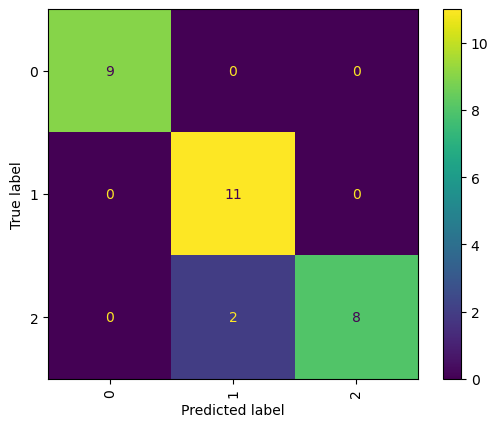

In [330]:
# Compute the metrics
compute_evaluation_metrics(svm, X_test, Y_test, unique_labels)

In line with our prior conclsuion, the performance of our SVM classifier is identical to that of our logistic regression calssifier. 

# Question Exercise 3: Neural networks

The MNIST dataset is a cornerstone in the field of computer vision and machine learning. It consists of a collection of 28x28 grayscale images of handwritten digits (0 through 9) and was originally created for training and testing various machine learning models because of its simplicity.

This dataset is available on **Keras**, where each image in the MNIST dataset represents a single digit and is accompanied by its corresponding label, denoting the digit it portrays.

LeNet-5, which we have seen in our class, is a pioneering CNN architecture developed by Yann LeCun and his collaborators in the late 1990s and was one of the first successful applications of CNNs to handwritten digit recognition. 


Implement a LeNet-5 structure using keras to train a model using the MNIST dataset. This is a suggested structure (you can apply another one):

1. **Convolutional Layer (CONV1)**:

    Parameters: Input (N) = 28 x 28 x 1, Kernel (K) = 5 x 5
    Activation: ReLu
    Apply 6 filters

<!-- Add an empty line here -->

2. **Average Pooling Layer (POOL1)**:

    Parameters: Kernel (K) = 2 x 2

<!-- Add an empty line here -->

3. **Convolutional Layer (CONV2)**:

    Parameters: Kernel (K) = 5 x 5
    Activation: ReLu
    Apply 16 filters

<!-- Add an empty line here -->

4. **Average Pooling Layer (POOL2)**:

    Parameters: Kernel (K) = 2 x 2

<!-- Add an empty line here -->

5. **Fully Connected layer (FC1)**:

    120 neurons
    Activation: ReLu

<!-- Add an empty line here -->

6. **Fully Connected layer (FC2)**:

    84 neurons
    Activation: ReLu

<!-- Add an empty line here -->

7. **Output layer (Softmax)**:

    10 neurons
    Activation: Softmax
    
Do not forget about the normalization of the pixel integers into [0,1] floats and to one-hot encode the labels!

Finally, evaluate and interpret the performance of the model by plotting the training history (including the loss and accuracy metrics for the test dataset) and discussing it.

# Answer Exercise 3: Neural Networks

First we need to load and preprocess the dataset. The code below loads the MNIST dataset, containing handwritten digit images and their corresponding labels, into the variables train_images, train_labels, test_images, and test_labels. 

Epoch 1/10
375/375 [==============================] - 15s 24ms/step - loss: 0.4884 - accuracy: 0.8571 - val_loss: 0.1714 - val_accuracy: 0.9496
Epoch 2/10
375/375 [==============================] - 8s 22ms/step - loss: 0.1479 - accuracy: 0.9546 - val_loss: 0.1119 - val_accuracy: 0.9672
Epoch 3/10
375/375 [==============================] - 9s 25ms/step - loss: 0.0983 - accuracy: 0.9701 - val_loss: 0.0934 - val_accuracy: 0.9712
Epoch 4/10
375/375 [==============================] - 9s 24ms/step - loss: 0.0784 - accuracy: 0.9759 - val_loss: 0.0688 - val_accuracy: 0.9795
Epoch 5/10
375/375 [==============================] - 10s 26ms/step - loss: 0.0628 - accuracy: 0.9799 - val_loss: 0.0687 - val_accuracy: 0.9803
Epoch 6/10
375/375 [==============================] - 9s 24ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 0.0647 - val_accuracy: 0.9803
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.0611 - val_accuracy: 0.98

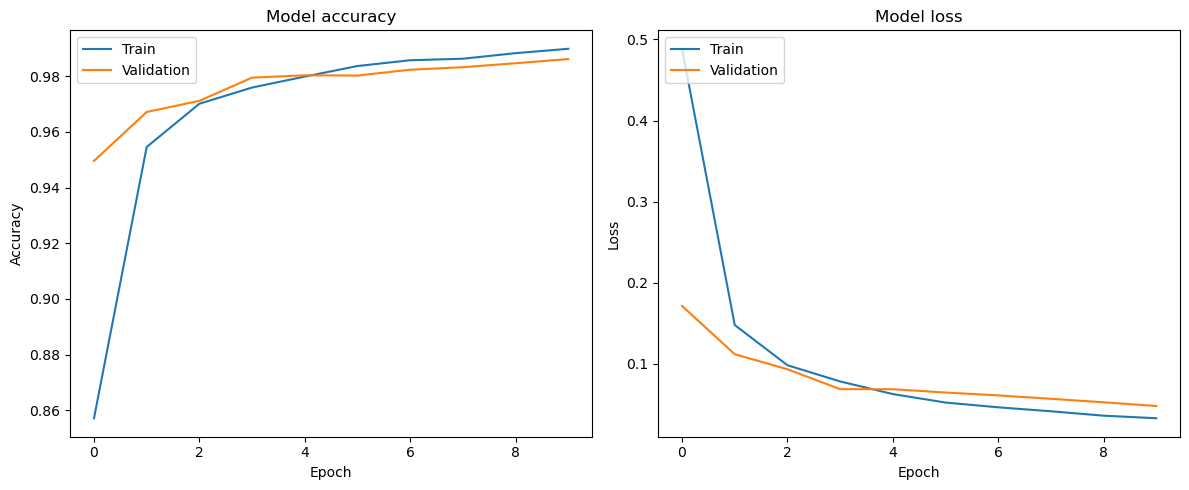

In [368]:


# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Build the LeNet-5 model
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(AveragePooling2D((2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu'))
model.add(AveragePooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [369]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()




This code below reshapes the pixel dimensions of the  training and test images and converts them to a 4D tensor format compatible with convolutional neural networks (CNNs). We normalizes the pixel values to a range between 0 and 1 by dividing each pixel by 255 (range of pixel values in images), thereby enhancing the stability, convergence speed, and generalization capabilities of the machine learning model.

In [370]:
# Normalize pixel values to be between 0 and 1
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255


Next we perform the one-hot encoding on the labels, transforming categorical labels into a binary matrix representation. This allows the use of categorical variables in models that require numerical input and ensures that the model can effectively learn and predict categorical outcomes during training.

In [371]:
# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


Next, the code below sets up the architecture of the LeNet-5 model using the Keras Sequential API for a digit classification task. I will provide some additional info to the rationale behind the steps:

* model = Sequential(): Initiates an empty neural network model using the Sequential API, where layers are added sequentially.
* model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1))): Adds a convolutional layer with 6 filters (feature detectors) of size 5x5, using the ReLU activation function. this layer scans small 5x5 regions of the input image (like a filter) to detect features, such as edges or patterns. The 6 filters in this layer learn different aspects of the image. The Rectified Linear Unit (ReLU) activation function helps introduce non-linearity to the model, allowing it to learn more complex patterns and relationships in the data.
* model.add(AveragePooling2D((2, 2))): Adds an average pooling layer for downsampeling. After convolution, this layer reduces the spatial dimensions by taking the average value within 2x2 regions. It helps retain the essential information while downsampling the data.
* model.add(Flatten()): Adds a flatten layer. It reshapes the 2D output from the previous layers into a 1D array, preparing it for fully connected layers.
* model.add(Dense(120, activation='relu')): In this line, we are adding a fully connected layer to our neural network. Think of this layer as a set of neurons where each neuron is connected to every neuron in the previous layer. The number 120 here represents the number of neurons in this layer.
* model.add(Dense(84, activation='relu')): Adds another fully connected layer with 84 neurons, promoting deeper understanding and learning of intricate details.
* model.add(Dense(10, activation='softmax')): Adds the output layer. The softmax activation function normalizes the output into probabilities, indicating the likelihood of the input image belonging to each of the 10 digit classes.


In [372]:
# LeNet-5 Model Definition in a sequential manner
model = Sequential()
# Convolutional Layer (Conv2D)
model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)))
# Average Pooling Layer (AveragePooling2D)
model.add(AveragePooling2D((2, 2)))
# Convolutional Layer (Conv2D)
model.add(Conv2D(16, (5, 5), activation='relu'))
# Average Pooling Layer (AveragePooling2D)
model.add(AveragePooling2D((2, 2)))
# Flatten Layer
model.add(Flatten())
# Fully Connected Layer (Dense)
model.add(Dense(120, activation='relu'))
# Fully Connected Layer (Dense)
model.add(Dense(84, activation='relu'))
# Output Layer (Dense)
model.add(Dense(10, activation='softmax'))

Now that we have added all the layers to our model, we can start to compile the model. We use 'adam' as optimizer. An optimizer  has the goal  to minimize the error or loss function, making the model more accurate in making predictions. The Adaptive Moment Estimation (adam) is quite a popular method that can dynamically adjust the learning rates for each of the parameters. It can adjust how big or small the steps are when the network is learning from data. By being dynamcally adaptive, it is able to speed up learning in some parts and slow down in others if necessary and thereby making the overall learning process faster. Here *loss* refers to the measure of how good the model is performing on the given task. We set loss to 'categorical_crossentropy' cause it is specifcally useful for dealing with multi-classifcation problems (as we have 10 digit classes). The metric of choice to assess the performance is accuracy (see Exercise 2 for the description)

In [373]:
# compile the model
model.compile(optimizer=SGD(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

Next, it is time to train the model! In line below, our model is trained on training dataset (x_train and y_train) for 10 epochs (1 epoch = 1 pass through entire training dataset), with a batch size of 128 (so 128 training examples in one epoch). Training progress is monitored, and our validation accuracy and loss are computed using a validation dataset (x_test and y_test). The verbose=2 parameter ensrues that the training progress will be displayed for each epoch. The training history, including accuracy and loss values, is stored in the history variable.

In [374]:
# train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10


375/375 [==============================] - 13s 25ms/step - loss: 0.8130 - accuracy: 0.7464 - val_loss: 0.2380 - val_accuracy: 0.9318
Epoch 2/10
375/375 [==============================] - 8s 21ms/step - loss: 0.2243 - accuracy: 0.9312 - val_loss: 0.1757 - val_accuracy: 0.9446
Epoch 3/10
375/375 [==============================] - 10s 28ms/step - loss: 0.1568 - accuracy: 0.9513 - val_loss: 0.1330 - val_accuracy: 0.9594
Epoch 4/10
375/375 [==============================] - 10s 25ms/step - loss: 0.1230 - accuracy: 0.9620 - val_loss: 0.1113 - val_accuracy: 0.9657
Epoch 5/10
375/375 [==============================] - 8s 22ms/step - loss: 0.1015 - accuracy: 0.9691 - val_loss: 0.1004 - val_accuracy: 0.9685
Epoch 6/10
375/375 [==============================] - 7s 20ms/step - loss: 0.0885 - accuracy: 0.9729 - val_loss: 0.0964 - val_accuracy: 0.9708
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.0779 - accuracy: 0.9762 - val_loss: 0.0840 - val_accuracy: 0.9732
Epoch 8

Next it's time to plot our training & validation accuracy andplot our training & validation loss. We use Matplotlib to create a subplot with two plots side by side from the history variable that we have just trained. In the plot on the left the training accuracy and validation accuracy over epochs is shown. In the plot on the right the training and validation loss over epochs is shown. 

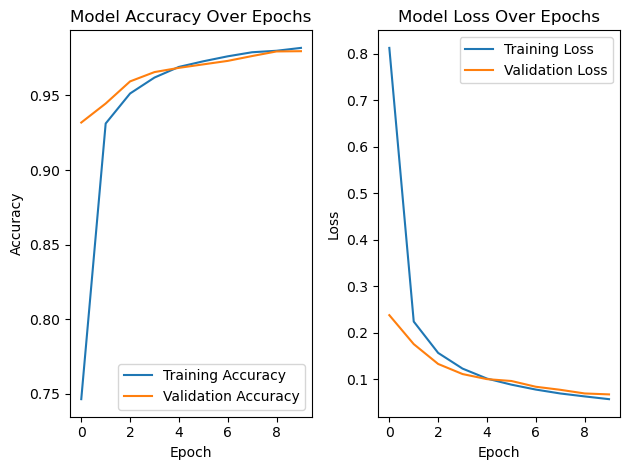

In [375]:
# plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



In [376]:
As you can see on the left hand side, with every epoch our models accuracy increases, both on the training dataset and on the validation dataset. On the right hand side we see our lowering with every epoch both in training and validation data. As stated before, loss quantifies the difference between the predicted values and the actual values (labels) in the dataset. As there are no major discrepancies between our training and validation accuracy and also not between our training and validation loss we can assume that no overfitting has taken place.

SyntaxError: invalid syntax (2344932473.py, line 1)